# Import Libraries

In [4]:
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import string
import numpy as np
from sklearn import metrics
from bs4 import BeautifulSoup
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW
import warnings
import seaborn as sns
import re
import emoji
import contractions

# Ignore warnings
warnings.filterwarnings('ignore')


# Load the dataset

In [6]:
# Define the path to the dataset directory
goemotions_path = "C:/Users/ROG/OneDrive - Syracuse University/IST736 Text Mining/final proj/EmotionDetection-main"

# Load the training data
train_df = pd.read_csv(f"{goemotions_path}/train.tsv", delimiter="\t", header=None, names=["Comment", "Class", "Delete"])
# Load the test data
test_df = pd.read_csv(f"{goemotions_path}/test.tsv", delimiter="\t", header=None, names=["Comment", "Class", "Delete"])
# Load the validation data
validation_df = pd.read_csv(f"{goemotions_path}/dev.tsv", delimiter="\t", header=None, names=["Comment", "Class", "Delete"])

GoEmotions is a dataset with 58000 Reddit comments labeled with 28 emotions:

admiration, amusement, anger, annoyance, approval, caring, confusion, curiosity, desire, disappointment, disapproval, disgust, embarrassment, excitement, fear, gratitude, grief, joy, love, nervousness, optimism, pride, realization, relief, remorse, sadness, surprise + neutral

In [10]:
train_df 

,Comment,Class,Delete
0,My favourite food is anything I didn't have to...,27,eebbqej
1,"Now if he does off himself, everyone will thin...",27,ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj
3,To make her feel threatened,14,ed7ypvh
4,Dirty Southern Wankers,3,ed0bdzj
...,...,...,...
43405,Added you mate well I’ve just got the bow and ...,18,edsb738
43406,Always thought that was funny but is it a refe...,6,ee7fdou
43407,What are you talking about? Anything bad that ...,3,efgbhks
43408,"More like a baptism, with sexy results!",13,ed1naf8


In [12]:
# dropping the "Delete" column
train_df = train_df.drop("Delete", axis=1)
test_df = test_df.drop("Delete", axis=1)
validation_df = validation_df.drop("Delete", axis=1)

In [14]:
print(train_df.shape)
print(test_df.shape)
print(validation_df.shape)

(43410, 2)
(5427, 2)
(5426, 2)


In [16]:
train_df.head()

,Comment,Class
0,My favourite food is anything I didn't have to...,27
1,"Now if he does off himself, everyone will thin...",27
2,WHY THE FUCK IS BAYLESS ISOING,2
3,To make her feel threatened,14
4,Dirty Southern Wankers,3


In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43410 entries, 0 to 43409
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  43410 non-null  object
 1   Class    43410 non-null  object
dtypes: object(2)
memory usage: 678.4+ KB


# Multiple Emotion Labels:
In the dataset, some comments are associated with multiple emotion labels, which are separated by commas in the "Class" column. To handle this, we create a "Class list" column by splitting the "Class" column string values into lists. This allows us to treat each comment's multiple labels as a list of labels, making it easier to analyze and manipulate the data.

In [21]:
# Create a new column "Class list" by splitting the "Class" column strings at each comma
train_df["Class list"] = train_df["Class"].apply(lambda x: x.split(","))
# Create a new column "Class len" that contains the length of each list in the "Class list" column
train_df["Class len"] = train_df["Class list"].apply(lambda x: len(x))

# Repeat the same process for the test data
test_df["Class list"] = test_df["Class"].apply(lambda x: x.split(","))
test_df["Class len"] = test_df["Class list"].apply(lambda x: len(x))

# Repeat the same process for the validation data
validation_df["Class list"] = validation_df["Class"].apply(lambda x: x.split(","))
validation_df["Class len"] = validation_df["Class list"].apply(lambda x: len(x))

In [23]:
train_df

,Comment,Class,Class list,Class len
0,My favourite food is anything I didn't have to...,27,[27],1
1,"Now if he does off himself, everyone will thin...",27,[27],1
2,WHY THE FUCK IS BAYLESS ISOING,2,[2],1
3,To make her feel threatened,14,[14],1
4,Dirty Southern Wankers,3,[3],1
...,...,...,...,...
43405,Added you mate well I’ve just got the bow and ...,18,[18],1
43406,Always thought that was funny but is it a refe...,6,[6],1
43407,What are you talking about? Anything bad that ...,3,[3],1
43408,"More like a baptism, with sexy results!",13,[13],1


In [25]:
# Filter rows where "Class len" is greater than 1
train_multiple_emotions = train_df[train_df["Class len"] > 1]
test_multiple_emotions = test_df[test_df["Class len"] > 1]
validation_multiple_emotions = validation_df[validation_df["Class len"] > 1]

In [27]:
# Display the rows with multiple emotion labels in the training data
print("Training Data - Rows with Multiple Emotion Labels:")
print(train_multiple_emotions)

Training Data - Rows with Multiple Emotion Labels:
                                                 Comment   Class  Class list  \
7      We need more boards and to create a bit more s...    8,20     [8, 20]   
11     Aww... she'll probably come around eventually,...     1,4      [1, 4]   
15     Shit, I guess I accidentally bought a Pay-Per-...    3,12     [3, 12]   
19     Maybe that’s what happened to the great white ...    6,22     [6, 22]   
20     I never thought it was at the same moment, but...  6,9,27  [6, 9, 27]   
...                                                  ...     ...         ...   
43382   goat handshake denied Personally, I just thin...   14,27    [14, 27]   
43383                                     it's horrid :/   14,27    [14, 27]   
43388  Fuck these trendy hipster joints. Give me my s...     2,3      [2, 3]   
43395  Sorry I kind of took it like you were flexing ...    1,24     [1, 24]   
43404  Your paranoia over it seems schizophrenic to m...    7,27     

In [29]:
# Display the rows with multiple emotion labels in the test data
print("\nTest Data - Rows with Multiple Emotion Labels:")
print(test_multiple_emotions)


Test Data - Rows with Multiple Emotion Labels:
                                                Comment  Class Class list  \
10    [NAME] has towed the line of the Dark Side. He...   3,10    [3, 10]   
11            Lol! But I love your last name though. XD   1,18    [1, 18]   
13    It's great that you're a recovering addict, th...    0,7     [0, 7]   
17    if the pain doesn't go away after 4 hours or s...  25,27   [25, 27]   
24    Watch Vegan Gains’ video on that, he had it wh...   6,27    [6, 27]   
...                                                 ...    ...        ...   
5404  Hahaha so I’m no longer going to worry about i...   1,20    [1, 20]   
5413  This will be me a year from now. Not fair at all.  10,12   [10, 12]   
5414  I know, right?! I was literally in tears Satur...   7,25    [7, 25]   
5415            They are children, they have no souls.     4,5     [4, 5]   
5419  My mom works for Nasa and apparently no. They ...   1,11    [1, 11]   

      Class len  
10       

In [31]:
# Display the rows with multiple emotion labels in the validation data
print("\nValidation Data - Rows with Multiple Emotion Labels:")
print(validation_multiple_emotions)


Validation Data - Rows with Multiple Emotion Labels:
                                                Comment   Class  Class list  \
1     You know the answer man, you are programmed to...    4,27     [4, 27]   
3     The economy is heavily controlled and subsidiz...    4,27     [4, 27]   
11    I went to a destination wedding being the only...   12,22    [12, 22]   
14    Lol dream on buddy. You’ve had enough attentio...  1,3,25  [1, 3, 25]   
15    As an anesthesia resident this made me blow ai...     2,3      [2, 3]   
...                                                 ...     ...         ...   
5395  Great cover of my favorite song. I loved watch...    0,18     [0, 18]   
5399                                   Damn this got me    3,27     [3, 27]   
5401                                  cool... Sorry bro   24,25    [24, 25]   
5405       Very very nice to see this irl. Nice post 👌🏼     0,4      [0, 4]   
5413  Yup! She was also on a show called Queen Bees ...     4,7      [4, 7]  

# Ekman’s Basic Emotions:
As mentioned above, GoEmotions uses 27 emotions to annotate Reddit comments. We are going to map these emotions to Ekman's 6 basic emotion categories: joy, anger, fear, sadness, disgust, and surprise

In [34]:
# Load the Ekman mapping JSON file
with open("C:/Users/ROG/OneDrive - Syracuse University/IST736 Text Mining/final proj/EmotionDetection-main/ekman_mapping.json") as file:
    ekman_mapping = json.load(file)

# Display the loaded JSON data
print(ekman_mapping)

{'anger': ['anger', 'annoyance', 'disapproval'], 'disgust': ['disgust'], 'fear': ['fear', 'nervousness'], 'joy': ['joy', 'amusement', 'approval', 'excitement', 'gratitude', 'love', 'optimism', 'relief', 'pride', 'admiration', 'desire', 'caring'], 'sadness': ['sadness', 'disappointment', 'embarrassment', 'grief', 'remorse'], 'surprise': ['surprise', 'realization', 'confusion', 'curiosity']}


In [36]:
emotion_file = open("C:/Users/ROG/OneDrive - Syracuse University/IST736 Text Mining/final proj/EmotionDetection-main/emotions.txt", "r")
emotion_list = emotion_file.read()
emotion_list = emotion_list.split("\n")
print(emotion_list)
print(len(emotion_list))

['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']
28


In [38]:
train_df

,Comment,Class,Class list,Class len
0,My favourite food is anything I didn't have to...,27,[27],1
1,"Now if he does off himself, everyone will thin...",27,[27],1
2,WHY THE FUCK IS BAYLESS ISOING,2,[2],1
3,To make her feel threatened,14,[14],1
4,Dirty Southern Wankers,3,[3],1
...,...,...,...,...
43405,Added you mate well I’ve just got the bow and ...,18,[18],1
43406,Always thought that was funny but is it a refe...,6,[6],1
43407,What are you talking about? Anything bad that ...,3,[3],1
43408,"More like a baptism, with sexy results!",13,[13],1


In [40]:
def idx2class(idxlist):
    arr = []
    for i in idxlist:
        arr.append(emotion_list[int(i)])
    return arr

In [42]:
# Converting the class indexes back to class names
train_df["Emotion"] = train_df["Class list"].apply(idx2class)
test_df["Emotion"] = test_df["Class list"].apply(idx2class)
validation_df["Emotion"] = validation_df["Class list"].apply(idx2class)

In [44]:
# Display rows with multiple emotions
train_df[train_df["Class len"] > 1]

,Comment,Class,Class list,Class len,Emotion
7,We need more boards and to create a bit more s...,"8,20","[8, 20]",2,"[desire, optimism]"
11,"Aww... she'll probably come around eventually,...","1,4","[1, 4]",2,"[amusement, approval]"
15,"Shit, I guess I accidentally bought a Pay-Per-...","3,12","[3, 12]",2,"[annoyance, embarrassment]"
19,Maybe that’s what happened to the great white ...,"6,22","[6, 22]",2,"[confusion, realization]"
20,"I never thought it was at the same moment, but...","6,9,27","[6, 9, 27]",3,"[confusion, disappointment, neutral]"
...,...,...,...,...,...
43382,"goat handshake denied Personally, I just thin...","14,27","[14, 27]",2,"[fear, neutral]"
43383,it's horrid :/,"14,27","[14, 27]",2,"[fear, neutral]"
43388,Fuck these trendy hipster joints. Give me my s...,"2,3","[2, 3]",2,"[anger, annoyance]"
43395,Sorry I kind of took it like you were flexing ...,"1,24","[1, 24]",2,"[amusement, remorse]"


In [46]:
def EmotionMapping(emotion_list):
    map_list = []
    
    for i in emotion_list:
        if i in ekman_mapping["anger"]:
            map_list.append("anger")
        if i in ekman_mapping["disgust"]:
            map_list.append("disgust")
        if i in ekman_mapping["fear"]:
            map_list.append("fear")
        if i in ekman_mapping["joy"]:
            map_list.append("joy")
        if i in ekman_mapping["sadness"]:
            map_list.append("sadness")
        if i in ekman_mapping["surprise"]:
            map_list.append("surprise")
        if i == "neutral":
            map_list.append("neutral")
            
    return map_list

In [48]:
# Convert the classes based on Ekman Taxonomy
train_df["Mapped_emotion"] = train_df["Emotion"].apply(EmotionMapping)
test_df["Mapped_emotion"] = test_df["Emotion"].apply(EmotionMapping)
validation_df["Mapped_emotion"] = validation_df["Emotion"].apply(EmotionMapping)

In [50]:
# Display rows with multiple emotions
train_df[train_df["Class len"] > 1]

,Comment,Class,Class list,Class len,Emotion,Mapped_emotion
7,We need more boards and to create a bit more s...,"8,20","[8, 20]",2,"[desire, optimism]","[joy, joy]"
11,"Aww... she'll probably come around eventually,...","1,4","[1, 4]",2,"[amusement, approval]","[joy, joy]"
15,"Shit, I guess I accidentally bought a Pay-Per-...","3,12","[3, 12]",2,"[annoyance, embarrassment]","[anger, sadness]"
19,Maybe that’s what happened to the great white ...,"6,22","[6, 22]",2,"[confusion, realization]","[surprise, surprise]"
20,"I never thought it was at the same moment, but...","6,9,27","[6, 9, 27]",3,"[confusion, disappointment, neutral]","[surprise, sadness, neutral]"
...,...,...,...,...,...,...
43382,"goat handshake denied Personally, I just thin...","14,27","[14, 27]",2,"[fear, neutral]","[fear, neutral]"
43383,it's horrid :/,"14,27","[14, 27]",2,"[fear, neutral]","[fear, neutral]"
43388,Fuck these trendy hipster joints. Give me my s...,"2,3","[2, 3]",2,"[anger, annoyance]","[anger, anger]"
43395,Sorry I kind of took it like you were flexing ...,"1,24","[1, 24]",2,"[amusement, remorse]","[joy, sadness]"


In [52]:
train_df["Mapped_emotion"] = train_df["Mapped_emotion"].apply(lambda x: ','.join(x))
test_df["Mapped_emotion"] = test_df["Mapped_emotion"].apply(lambda x: ','.join(x))
validation_df["Mapped_emotion"] = validation_df["Mapped_emotion"].apply(lambda x: ','.join(x))

In [54]:
# Display rows with multiple emotions
train_df[train_df["Class len"] > 1]

,Comment,Class,Class list,Class len,Emotion,Mapped_emotion
7,We need more boards and to create a bit more s...,"8,20","[8, 20]",2,"[desire, optimism]","joy,joy"
11,"Aww... she'll probably come around eventually,...","1,4","[1, 4]",2,"[amusement, approval]","joy,joy"
15,"Shit, I guess I accidentally bought a Pay-Per-...","3,12","[3, 12]",2,"[annoyance, embarrassment]","anger,sadness"
19,Maybe that’s what happened to the great white ...,"6,22","[6, 22]",2,"[confusion, realization]","surprise,surprise"
20,"I never thought it was at the same moment, but...","6,9,27","[6, 9, 27]",3,"[confusion, disappointment, neutral]","surprise,sadness,neutral"
...,...,...,...,...,...,...
43382,"goat handshake denied Personally, I just thin...","14,27","[14, 27]",2,"[fear, neutral]","fear,neutral"
43383,it's horrid :/,"14,27","[14, 27]",2,"[fear, neutral]","fear,neutral"
43388,Fuck these trendy hipster joints. Give me my s...,"2,3","[2, 3]",2,"[anger, annoyance]","anger,anger"
43395,Sorry I kind of took it like you were flexing ...,"1,24","[1, 24]",2,"[amusement, remorse]","joy,sadness"


In [56]:
train_df_1= train_df["Mapped_emotion"].str.split(",", expand=True)
test_df_1= test_df["Mapped_emotion"].str.split(",", expand=True)
validation_df_1= validation_df["Mapped_emotion"].str.split(",", expand=True)

In [58]:
train_df_1[train_df_1.notna().all(axis=1)]

,0,1,2,3,4
7873,sadness,sadness,fear,fear,sadness


In [60]:
train_df_1.drop(train_df_1.columns[1:5], axis=1, inplace=True)
test_df_1.drop(test_df_1.columns[1:5], axis=1, inplace=True)
validation_df_1.drop(validation_df_1.columns[1:5], axis=1, inplace=True)

In [62]:
train_df_1

,0
0,neutral
1,neutral
2,anger
3,fear
4,anger
...,...
43405,joy
43406,surprise
43407,anger
43408,joy


In [64]:
train_df = pd.concat([train_df, train_df_1], axis=1)
test_df = pd.concat([test_df, test_df_1], axis=1)
validation_df = pd.concat([validation_df, validation_df_1], axis=1)

In [66]:
# Display rows with multiple emotions
train_df[train_df["Class len"] > 1]

,Comment,Class,Class list,Class len,Emotion,Mapped_emotion,0
7,We need more boards and to create a bit more s...,"8,20","[8, 20]",2,"[desire, optimism]","joy,joy",joy
11,"Aww... she'll probably come around eventually,...","1,4","[1, 4]",2,"[amusement, approval]","joy,joy",joy
15,"Shit, I guess I accidentally bought a Pay-Per-...","3,12","[3, 12]",2,"[annoyance, embarrassment]","anger,sadness",anger
19,Maybe that’s what happened to the great white ...,"6,22","[6, 22]",2,"[confusion, realization]","surprise,surprise",surprise
20,"I never thought it was at the same moment, but...","6,9,27","[6, 9, 27]",3,"[confusion, disappointment, neutral]","surprise,sadness,neutral",surprise
...,...,...,...,...,...,...,...
43382,"goat handshake denied Personally, I just thin...","14,27","[14, 27]",2,"[fear, neutral]","fear,neutral",fear
43383,it's horrid :/,"14,27","[14, 27]",2,"[fear, neutral]","fear,neutral",fear
43388,Fuck these trendy hipster joints. Give me my s...,"2,3","[2, 3]",2,"[anger, annoyance]","anger,anger",anger
43395,Sorry I kind of took it like you were flexing ...,"1,24","[1, 24]",2,"[amusement, remorse]","joy,sadness",joy


In [68]:
train_df.rename(columns={0: "Single_emotion"}, inplace=True)
test_df.rename(columns={0: "Single_emotion"}, inplace=True)
validation_df.rename(columns={0: "Single_emotion"}, inplace=True)

In [70]:
train_df[train_df["Class len"] > 1]

,Comment,Class,Class list,Class len,Emotion,Mapped_emotion,Single_emotion
7,We need more boards and to create a bit more s...,"8,20","[8, 20]",2,"[desire, optimism]","joy,joy",joy
11,"Aww... she'll probably come around eventually,...","1,4","[1, 4]",2,"[amusement, approval]","joy,joy",joy
15,"Shit, I guess I accidentally bought a Pay-Per-...","3,12","[3, 12]",2,"[annoyance, embarrassment]","anger,sadness",anger
19,Maybe that’s what happened to the great white ...,"6,22","[6, 22]",2,"[confusion, realization]","surprise,surprise",surprise
20,"I never thought it was at the same moment, but...","6,9,27","[6, 9, 27]",3,"[confusion, disappointment, neutral]","surprise,sadness,neutral",surprise
...,...,...,...,...,...,...,...
43382,"goat handshake denied Personally, I just thin...","14,27","[14, 27]",2,"[fear, neutral]","fear,neutral",fear
43383,it's horrid :/,"14,27","[14, 27]",2,"[fear, neutral]","fear,neutral",fear
43388,Fuck these trendy hipster joints. Give me my s...,"2,3","[2, 3]",2,"[anger, annoyance]","anger,anger",anger
43395,Sorry I kind of took it like you were flexing ...,"1,24","[1, 24]",2,"[amusement, remorse]","joy,sadness",joy


In [72]:
#Checking if the data is balanced or not
train_df.Single_emotion.value_counts()

Single_emotion
joy         16948
neutral     12823
anger        5336
surprise     4489
sadness      2619
fear          615
disgust       580
Name: count, dtype: int64

In [74]:
train_df.head()

,Comment,Class,Class list,Class len,Emotion,Mapped_emotion,Single_emotion
0,My favourite food is anything I didn't have to...,27,[27],1,[neutral],neutral,neutral
1,"Now if he does off himself, everyone will thin...",27,[27],1,[neutral],neutral,neutral
2,WHY THE FUCK IS BAYLESS ISOING,2,[2],1,[anger],anger,anger
3,To make her feel threatened,14,[14],1,[fear],fear,fear
4,Dirty Southern Wankers,3,[3],1,[annoyance],anger,anger


In [ ]:
# List of columns to drop
columns_to_drop = ['Class list', 'Emotion']

# Drop the specified columns
train_df = train_df.drop(columns=columns_to_drop)
test_df = test_df.drop(columns=columns_to_drop)
validation_df = validation_df.drop(columns=columns_to_drop)

In [87]:
train_df

,Comment,Class,Class len,Mapped_emotion,Single_emotion
0,My favourite food is anything I didn't have to...,27,1,neutral,neutral
1,"Now if he does off himself, everyone will thin...",27,1,neutral,neutral
2,WHY THE FUCK IS BAYLESS ISOING,2,1,anger,anger
3,To make her feel threatened,14,1,fear,fear
4,Dirty Southern Wankers,3,1,anger,anger
...,...,...,...,...,...
43405,Added you mate well I’ve just got the bow and ...,18,1,joy,joy
43406,Always thought that was funny but is it a refe...,6,1,surprise,surprise
43407,What are you talking about? Anything bad that ...,3,1,anger,anger
43408,"More like a baptism, with sexy results!",13,1,joy,joy


In [89]:
# Check duplicated values
print("Train data:", train_df.duplicated().sum())
print("Test data:", test_df.duplicated().sum())
print("Validation data:", validation_df.duplicated().sum())

Train data: 113
Test data: 5
Validation data: 2


In [91]:
#Removing Duplicated values
index = train_df[train_df.duplicated() == True].index
train_df.drop(index, axis=0, inplace=True)
train_df.reset_index(inplace=True, drop=True)

index = test_df[test_df.duplicated() == True].index
test_df.drop(index, axis=0, inplace=True)
test_df.reset_index(inplace=True, drop=True)

index = validation_df[validation_df.duplicated() == True].index
validation_df.drop(index, axis=0, inplace=True)
validation_df.reset_index(inplace=True, drop=True)

In [93]:
# Check duplicated values
print("Train data:", train_df.duplicated().sum())
print("Test data:", test_df.duplicated().sum())
print("Validation data:", validation_df.duplicated().sum())

Train data: 0
Test data: 0
Validation data: 0


In [95]:
#print rows which are duplicated in the text but the same emotion
train_df[train_df["Comment"].duplicated() == True]

,Comment,Class,Class len,Mapped_emotion,Single_emotion
4617,I miss [NAME],25,1,sadness,sadness
6274,Happy cake day!,13,1,joy,joy
6549,Happy cake day!,"13,17",2,"joy,joy",joy
6613,My man!,21,1,joy,joy
7928,What do you mean?,7,1,surprise,surprise
...,...,...,...,...,...
41162,So edgy.,14,1,fear,fear
41578,This hurts my brain,25,1,sadness,sadness
41756,"A surprise to be sure, but a welcome one.",13,1,joy,joy
41961,Love your username!,0,1,joy,joy


In [97]:
# Removing the duplicate text
index = train_df[train_df["Comment"].duplicated() == True].index
train_df.drop(index, axis=0, inplace = True)
train_df.reset_index(inplace=True, drop=True)

In [99]:
#print rows which are duplicated in the text but the same emotion
test_df[test_df["Comment"].duplicated() == True]

,Comment,Class,Class len,Mapped_emotion,Single_emotion
4814,Happy cake day!,17,1,joy,joy


In [101]:
#print rows which are duplicated in the text but the same emotion
validation_df[validation_df["Comment"].duplicated() == True]

,Comment,Class,Class len,Mapped_emotion,Single_emotion
5236,I like it!,0,1,joy,joy


# Data Preprocessing

In [175]:
def replace_multiple_occurrences(text):
    # Define a pattern to match consecutive letters repeated more than twice; example "coooool" turns into --> cool
    pattern = r"(\w)(\1{2,})"  # Matches a letter (\w) followed by the same letter repeated 2 or more times
    
    # Use a lambda function to handle replacements
    processed_text = re.sub(pattern, lambda m: m.group(1) * 2, text)
    
    return processed_text
def preprocess_comments(x):
    
    # Adding a space between words and punctuation
    x = re.sub(r'([a-zA-Z])([,;.!?])', r'\1 \2', x)
    x = re.sub(r'([,;.!?])([a-zA-Z])', r'\1 \2', x)

    # Demojize emojis
    x = emoji.demojize(x)

    # Expand contractions
    x = contractions.fix(x)

    # Convert to lowercase
    x = x.lower()

    # Correct acronyms/typos/abbreviations  
    x = re.sub(r"lmao", "laughing my ass off", x)  
    x = re.sub(r"amirite", "am i right", x)
    x = re.sub(r"\b(tho)\b", "though", x)
    x = re.sub(r"\b(ikr)\b", "i know right", x)
    x = re.sub(r"\b(ya|u)\b", "you", x)
    x = re.sub(r"\b(eu)\b", "europe", x)
    x = re.sub(r"\b(da)\b", "the", x)
    x = re.sub(r"\b(dat)\b", "that", x)
    x = re.sub(r"\b(dats)\b", "that is", x)
    x = re.sub(r"\b(cuz)\b", "because", x)
    x = re.sub(r"\b(fkn)\b", "fucking", x)
    x = re.sub(r"\b(tbh)\b", "to be honest", x)
    x = re.sub(r"\b(tbf)\b", "to be fair", x)
    x = re.sub(r"faux pas", "mistake", x)
    x = re.sub(r"\b(btw)\b", "by the way", x)
    x = re.sub(r"\b(bs)\b", "bullshit", x)
    x = re.sub(r"\b(kinda)\b", "kind of", x)
    x = re.sub(r"\b(bruh)\b", "bro", x)
    x = re.sub(r"\b(w/e)\b", "whatever", x)
    x = re.sub(r"\b(w/)\b", "with", x)
    x = re.sub(r"\b(w/o)\b", "without", x)
    x = re.sub(r"\b(doj)\b", "department of justice", x)
    
    # Handling emojis
    x = re.sub(r"<3", " love ", x)
    x = re.sub(r"xd", " smiling_face_with_open_mouth_and_tightly_closed_eyes ", x)
    x = re.sub(r":\)", " smiling_face ", x)
    x = re.sub(r"^_^", " smiling_face ", x)
    x = re.sub(r"\*_\*", " star_struck ", x)
    x = re.sub(r":\(", " frowning_face ", x)
    x = re.sub(r":\^\(", " frowning_face ", x)
    x = re.sub(r";\(", " frowning_face ", x)
    x = re.sub(r":\/",  " confused_face", x)
    x = re.sub(r";\)",  " wink", x)
    x = re.sub(r">__<",  " unamused ", x)
    x = re.sub(r"\b([xo]+x*)\b", " xoxo ", x)
    x = re.sub(r"\b(n+a+h+)\b", "no", x)

    # Handling special cases of text
    x = re.sub(r"h a m b e r d e r s", "hamberders", x)
    x = re.sub(r"b e n", "ben", x)
    x = re.sub(r"y i k e s", "yikes", x)
    x = re.sub(r"s p o i l e r", "spoiler", x)
    x = re.sub(r"thankyou", "thank you", x)
    x = re.sub(r"a^r^o^o^o^o^o^o^o^n^d", "around", x)

    # Replace words with multiple occurrences of a letter
    x = replace_multiple_occurrences(x)

    # Remove special characters, numbers, and replace by space
    x = re.sub(r"\b([.]{3,})", " dots ", x)
    x = re.sub(r"[^A-Za-z!?_]+", " ", x)
    x = re.sub(r"\b([s])\b *", "", x)
    x = re.sub(r" +", " ", x)
    x = x.strip()

    return x


In [176]:
train_df['Comment'] = train_df['Comment'].apply(preprocess_comments)
test_df['Comment'] = test_df['Comment'].apply(preprocess_comments)
validation_df['Comment'] = validation_df['Comment'].apply(preprocess_comments)

In [141]:
train_df[300:320]

,Comment,Class,Class len,Mapped_emotion,Single_emotion,Single_class
300,r/hockey has no love for us! Just stay here wi...,27,1,neutral,neutral,27
301,They don't seem to care much. Al qaida or ahra...,10,1,anger,anger,10
302,the number 9 recruit from the 2019 class at US...,1,1,joy,joy,1
303,nah me good,27,1,neutral,neutral,27
304,I have his signature on my jersey. Lined up at...,17,1,joy,joy,17
305,Every day it gets harder to tell the differenc...,"3,9",2,"anger,sadness",anger,3
306,I am just like this! Glad to know I’m not imag...,21,1,joy,joy,21
307,I do not understand why everything in this scr...,27,1,neutral,neutral,27
308,The logic is so the government can oppress you.,27,1,neutral,neutral,27
309,Oh yeah! He was great for us. 0.69 ERA in 24 G...,0,1,joy,joy,0


In [145]:
# add a single class and convert it to integer
train_df['Single_class'] = train_df['Class'].apply(lambda x: str(x).split(',')[0] if isinstance(x, str) else x)
train_df['Single_class'] = train_df['Single_class'].astype('int32')

test_df['Single_class'] = test_df['Class'].apply(lambda x: str(x).split(',')[0] if isinstance(x, str) else x)
test_df['Single_class'] = test_df['Single_class'].astype('int32')

validation_df['Single_class'] = validation_df['Class'].apply(lambda x: str(x).split(',')[0] if isinstance(x, str) else x)
validation_df['Single_class'] = validation_df['Single_class'].astype('int32')

# Distribution of Emotions

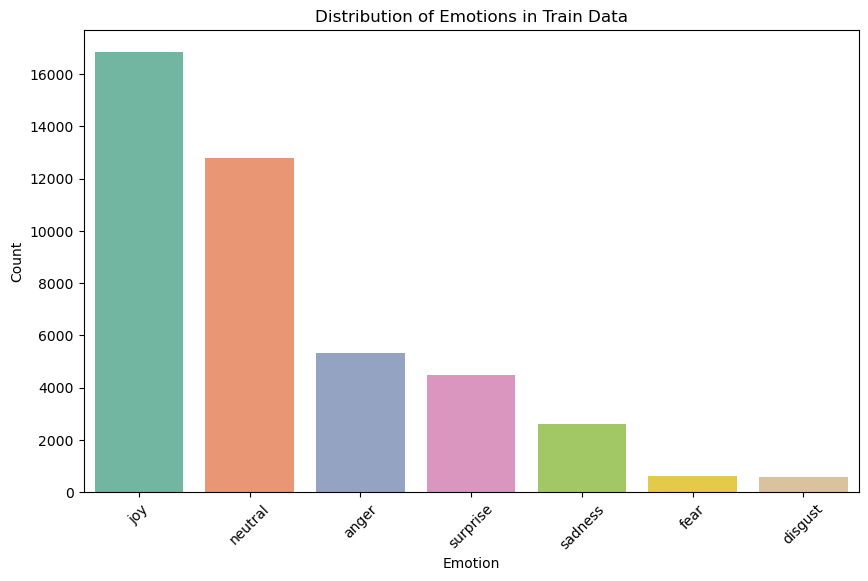

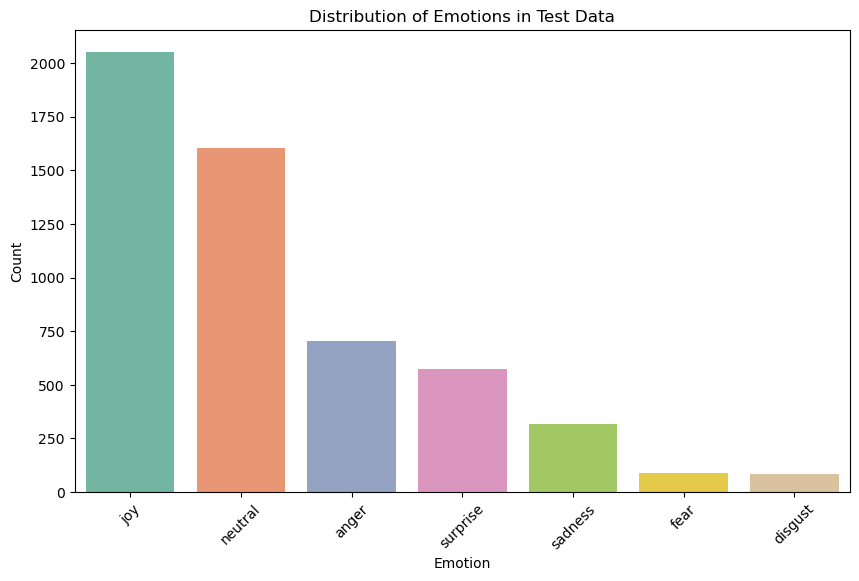

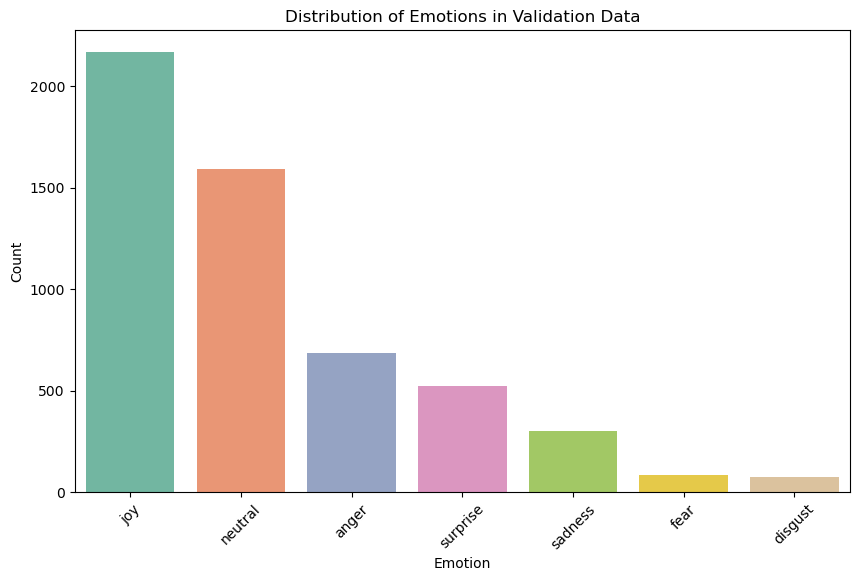

In [179]:
# Define a color palette with different colors for each emotion
colors = sns.color_palette("Set2", n_colors=7)  # Adjust n_colors as per your need

# Plotting for train_df
plt.figure(figsize=(10, 6))
sns.countplot(x='Single_emotion', data=train_df, order=train_df['Single_emotion'].value_counts().index, palette=colors)
plt.title('Distribution of Emotions in Train Data')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Plotting for test_df
plt.figure(figsize=(10, 6))
sns.countplot(x='Single_emotion', data=test_df, order=test_df['Single_emotion'].value_counts().index, palette=colors)
plt.title('Distribution of Emotions in Test Data')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Plotting for validation_df
plt.figure(figsize=(10, 6))
sns.countplot(x='Single_emotion', data=validation_df, order=validation_df['Single_emotion'].value_counts().index, palette=colors)
plt.title('Distribution of Emotions in Validation Data')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# LSTM

In [107]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [129]:
y_train_single = np.array([label[0] if isinstance(label, (list, tuple, np.ndarray)) else label for label in y_train])
# y_train_single = y_train_single.astype('int32')

# print(type(y_train_single))
# print(y_train_single.dtype)
print(y_train_single[:10])

['27' '27' '2' '14' '3' '26' '15' '8,20' '0' '27']


In [147]:
train_comments = train_df['Comment']  # train comment
train_labels = train_df['Single_class']  # train class

test_comments = test_df['Comment']  # test comment
test_labels = test_df['Single_class'] # test class

# set parameters for word list and sentence length
max_words = 10000  # worlist
max_len = 100  # sentence
embedding_dim = 100  # debedding dimensions

# tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_comments)


In [151]:
# convert train data into sequences
X_train = tokenizer.texts_to_sequences(train_comments)
X_train = pad_sequences(X_train, maxlen=max_len)
y_train = np.array(train_labels)

# convert test data into sequences
X_test = tokenizer.texts_to_sequences(test_comments)
X_test = pad_sequences(X_test, maxlen=max_len)
y_test = np.array(test_labels)

# initial LSTM model
model = Sequential([
    Embedding(max_words, embedding_dim, input_length=max_len),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(28, activation='softmax')  # assume 5 emotions
])

# complie the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# train the model for 10 epochs
history = model.fit(X_train, y_train, 
                    epochs=10, 
                    batch_size=32, 
                    validation_split=0.1,  # take 10% for validation each step
                    verbose=1)

# evaluate
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f'Test accuracy: {test_acc}')

# predicting
predictions = model.predict(X_test)

Epoch 1/10
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.3264 - loss: 2.6168 - val_accuracy: 0.4550 - val_loss: 2.0929
Epoch 2/10
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.4921 - loss: 1.8762 - val_accuracy: 0.5080 - val_loss: 1.8510
Epoch 3/10
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.5631 - loss: 1.5283 - val_accuracy: 0.5145 - val_loss: 1.7943
Epoch 4/10
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6200 - loss: 1.3046 - val_accuracy: 0.5017 - val_loss: 1.8459
Epoch 5/10
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.6697 - loss: 1.1273 - val_accuracy: 0.4858 - val_loss: 1.9177
Epoch 6/10
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.7115 - loss: 0.9830 - val_accuracy: 0.4652 - val_loss: 2.0219
Epoch 7/10
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.7429 - loss: 0.8665 - val_accuracy: 0.4576 - val_loss: 2.1645
Epoch 8/10
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.7785 -